In [148]:
from collections import OrderedDict, defaultdict
from typing import Sequence

import matplotlib.pyplot as plt
import numpy as np
from gpaw import restart
from gpaw.lcao.pwf2 import LCAOwrap
from gpaw.typing import Array2D
from matplotlib.colors import LinearSegmentedColormap, LogNorm
from qtpyt.basis import Basis
from qtpyt.lo.tools import lowdin_rotation, rotate_matrix, subdiagonalize_atoms
from scipy.linalg import eigh

In [149]:
def get_subspace(A_MM: Array2D, indices: Sequence[int]):
    """Get the subspace spanned by the basis function listed in index."""
    assert A_MM.ndim == 2 and A_MM.shape[0] == A_MM.shape[1]
    return A_MM.take(indices, 0).take(indices, 1)


def get_orthonormal_subspace(H_MM: Array2D,
                             S_MM: Array2D,
                             indices: Sequence[int] = None):
    """Get orthonormal eigenvalues and -vectors of subspace listed in index."""
    if indices is not None:
        h_ww = get_subspace(H_MM, indices)
        s_ww = get_subspace(S_MM, indices)
    else:
        h_ww = H_MM
        s_ww = S_MM
    eps, v = eigh(h_ww, s_ww)
    return eps, v


def subdiagonalize(H_MM: Array2D,
                   S_MM: Array2D,
                   blocks: Sequence[Sequence[int]]):
    """Subdiagonalize blocks."""
    nM = len(H_MM)
    v_MM = np.eye(nM)
    eps_M = np.zeros(nM)
    mask_M = np.ones(nM, dtype=int)
    for block in blocks:
        eps, v = get_orthonormal_subspace(H_MM, S_MM, block)
        v_MM[np.ix_(block, block)] = v
        eps_M[block] = eps
        mask_M[block] = 0
    epsx_M = np.ma.masked_array(eps_M, mask=mask_M)  # type: ignore
    return epsx_M, v_MM

In [150]:
class Subdiagonalization:
    """Class to perform a subdiagonalization of the Hamiltonian.

    Attributes
    ----------
    blocks : list of array_like
        List of blocks to subdiagonalize.
    H_MM, S_MM : array_like
        2-D LCAO Hamiltonian and overlap matrices.
    U_MM : array_like
        2-D rotation matrix that subdiagonalizes the LCAO Hamiltonian.
    eps_M : array_like
        1-D array of local orbital energies.

    Methods
    -------
    group_energies(round=1)
        Group local orbitals based on energy
    group_symmetries(cutoff=0.9)
        Group local orbitals based on symmetries and energy.
    get_effective_model(indices, ortho=None)
        Builds and effective model from an array of indices.

    """

    def __init__(self,
                 H_MM: Array2D,
                 S_MM: Array2D,
                 blocks: Sequence[Sequence[int]]) -> None:
        """

        Parameters
        ----------
        See class docstring

        """
        self.blocks = blocks
        self.H_MM = H_MM
        self.S_MM = S_MM
        self.eps_M, self.U_MM = subdiagonalize(
            self.H_MM, self.S_MM, blocks)
        self.groups: dict[float, list[int]] | None = None

    def group_energies(self, decimals: int = 1):
        """Group local orbitals with a similar energy.

        Parameters
        ----------
        decimals : int
            Round energies to the given number of decimals.

        """
        eps = self.eps_M.round(decimals)
        show = np.where(~eps.mask)[0]
        groups = defaultdict(list)
        for index in show:
            groups[eps[index]].append(index)

        self.groups = groups
        return self.groups

    def group_symmetries(self, decimals: int = 1, cutoff: float = 0.9):
        """Group local orbitals with a similar spatial symmetry and energy.

        Parameters
        ----------
        decimals : int
            Round energies to the given number of decimals.
        cutoff : float
            Sets minimum degree of overlap. Can be any value between 0 and 1.

        """
        col_1: list[int] = []  # Keyword.
        col_2: list[int] = []  # Value.
        groups = defaultdict(set)
        blocks = self.blocks
        # Loop over pair of blocks.
        for b1, b2 in zip(*np.triu_indices(len(blocks), k=1)):
            if len(blocks[b1]) != len(blocks[b2]):
                # Blocks with different dimensions not compatible.
                continue
            U1 = self.U_MM[np.ix_(blocks[b1], blocks[b1])]
            U2 = self.U_MM[np.ix_(blocks[b2], blocks[b2])]
            # Compute pair overlap between orbitals in the two blocks.
            for o1, o2 in np.ndindex(len(blocks[b1]), len(blocks[b1])):
                v1 = abs(U1[:, o1])
                v2 = abs(U2[:, o2])
                o12 = 2 * v1.dot(v2) / (v1.dot(v1) + v2.dot(v2))
                # Overlap larger than cutoff?
                if o12 >= cutoff:
                    # Yes.
                    i1 = blocks[b1][o1]
                    i2 = blocks[b2][o2]
                    # Use orbital with minimal index as keyword.
                    i1, i2 = min(i1, i2), max(i1, i2)
                    # Check if `i1` is already present in `col_2` and
                    # use corresponding keyword in col_1 instead.
                    present = False
                    for i, i3 in enumerate(col_2):
                        if i1 == i3:
                            present = True
                            break
                    if present:
                        a1 = col_1[i]
                    else:
                        a1 = i1
                    col_1.append(a1)
                    col_2.append(i2)
                    groups[a1].add(i2)
        # Try to further group by energy.
        new: dict[float, list[int]] = defaultdict(list)
        for k, v in groups.items():
            v.add(k)
            new[self.eps_M[k].round(decimals)] += groups[k]
        self.groups = {k: list(sorted(new[k])) for k in sorted(new)}  # groups
        return self.groups

    @staticmethod
    def sort_indices_by_energy(input_dict, ascending=True):
        sorted_dict = OrderedDict(sorted(input_dict.items(), reverse=not ascending))
        sorted_indices = [index for sublist in sorted_dict.values() for index in sublist]
        return sorted_indices

In [151]:

lowdin = True

gpwfile = '/home/anooja/Desktop/test/AuBDA/dft/device_dzp/scatt.gpw'
hsfile = 'hs_lolw_k.npy'
hlcaofile = 'hs_lcao.npy'


atoms, calc = restart(gpwfile, txt=None)
lcao = LCAOwrap(calc)

fermi = calc.get_fermi_level()
H = lcao.get_hamiltonian()
S = lcao.get_overlap()
H -= fermi * S

# np.save(hlcaofile, (H[None,...],S[None,...]))

Condition number: 4.8e+04


In [152]:
def create_map(atom_list, nao_a):
    mapping = {}
    for atom, nao in zip(atom_list, nao_a):
        mapping[atom] = nao
    return mapping

In [153]:
nao_per_atom = np.array([setup.nao for setup in calc.wfs.setups])
basis = Basis(atoms, nao_per_atom)

x = basis.atoms.positions[:, 0]
scattering_region = np.where((x > 12.9) & (x < 22))[0]
element = 'C'
atom_list = atoms.get_chemical_symbols()
mapping = create_map(atom_list, nao_per_atom)
max_nao = mapping[element]
spherical_harmonic_index = list(range(max_nao))
active_space = [
    {element:spherical_harmonic_index},
                ]
basis_scattering_region = basis[scattering_region]
index_scattering_region = basis_scattering_region.get_indices()
for active in active_space:
    index_active_space = basis_scattering_region.extract().take(active)

In [154]:
C_block = [index_active_space[i:i + max_nao] for i in range(0, len(index_active_space), max_nao)]
C_block_external = [C_block[0], C_block[-1]] #obtained by visual inspection of index_Active_space
C_block_internal = C_block[1:-1]


In [201]:
subdiag = Subdiagonalization(H,S,C_block_external)
energy_group = subdiag.group_energies()
energy_group

defaultdict(list,
            {-5.3: [23, 108],
             -4.3: [24, 25, 109, 110],
             -4.2: [26, 111],
             -4.1: [27, 28],
             -2.8: [29],
             -2.7: [30, 31, 32, 112, 113],
             14.5: [33],
             14.6: [34, 35, 115, 116, 117],
             -1.9: [114],
             15.7: [118, 119],
             16.5: [120]})

In [159]:
colors = [(1, 1, 1),(0.5, 0, 0)]

In [160]:
Usub, eig = subdiagonalize_atoms(basis, H, S, a=scattering_region)
for active in active_space:
    index_active_space = basis_scattering_region.extract().take(active)
    # Positive projection onto p-z AOs
    for idx_lo in index_scattering_region[index_active_space]:
        if Usub[idx_lo - 1, idx_lo] < 0.:  # change sign
            Usub[:, idx_lo] *= -1

    H = rotate_matrix(H, Usub)
    S = rotate_matrix(S, Usub)

    if lowdin:
        Ulow = lowdin_rotation(H, S, index_scattering_region[index_active_space])

        H = rotate_matrix(H, Ulow)
        S = rotate_matrix(S, Ulow)

        U = Usub.dot(Ulow)

    # np.save(hsfile, (H[None,...],S[None,...]))


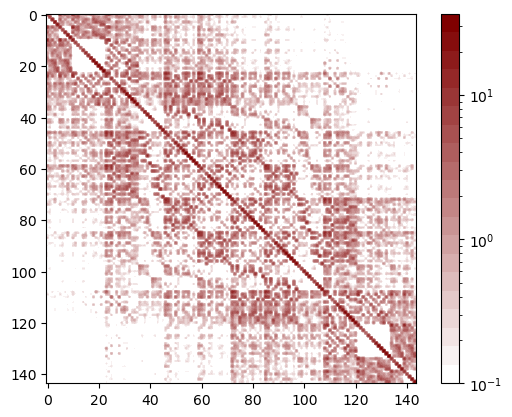

In [161]:
lindex = index_scattering_region[0]
uindex = index_scattering_region[-1]+1
H_scattering_region = H[lindex:uindex,lindex:uindex]
cm = LinearSegmentedColormap.from_list(
        "Custom", colors, N=20)
plt.imshow(abs(H_scattering_region), cmap=cm,norm=LogNorm(vmin=0.1))
plt.colorbar()

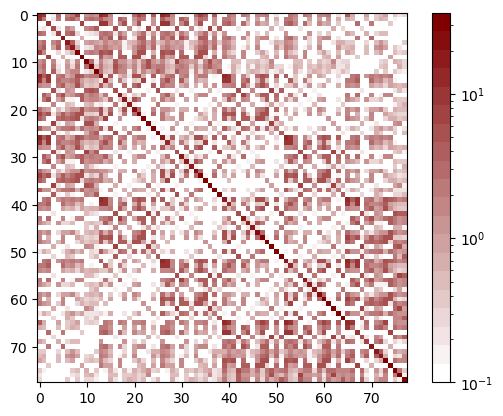

In [162]:
n = len(index_active_space)
H_C_atoms = np.zeros((n, n))
for i, idx_i in enumerate(index_active_space):
    for j, idx_j in enumerate(index_active_space):
        H_C_atoms[i, j] = H_scattering_region[idx_i, idx_j]

cm = LinearSegmentedColormap.from_list(
        "Custom", colors, N=20)
plt.imshow(abs(H_C_atoms), cmap=cm,norm=LogNorm(vmin=0.1))
plt.colorbar()

In [193]:
symmetry_group = subdiag.group_symmetries(cutoff=0.9)
index_grouped_by_symmetry = []
for indices in symmetry_group.values():
    index_grouped_by_symmetry.extend(indices)


In [194]:
print(symmetry_group)

{-4.2: [26, 108], 14.5: [33, 112], 14.6: [34, 113]}


6


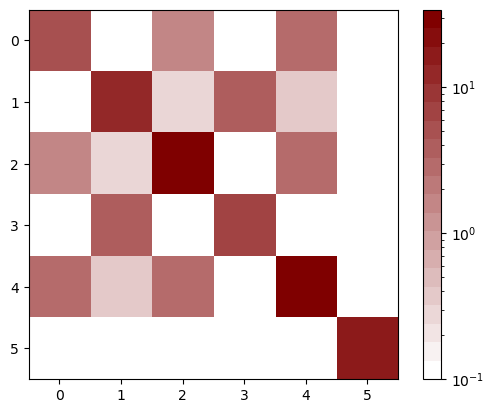

In [196]:
n = len(index_grouped_by_symmetry)
H_C_atoms = np.zeros((n, n))
for i, idx_i in enumerate(index_grouped_by_symmetry):
    for j, idx_j in enumerate(index_grouped_by_symmetry):
        H_C_atoms[i, j] = H_scattering_region[idx_i, idx_j]

cm = LinearSegmentedColormap.from_list(
        "Custom", colors, N=20)
plt.imshow(abs(H_C_atoms), cmap=cm,norm=LogNorm(vmin=0.1))
plt.colorbar()

In [199]:
index_grouped_by_energy = Subdiagonalization.sort_indices_by_energy(energy_group, ascending=True)

26


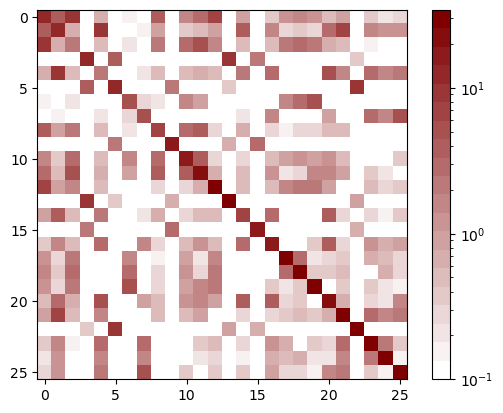

In [200]:
n = len(index_grouped_by_energy)
H_C_atoms = np.zeros((n, n))
for i, idx_i in enumerate(index_grouped_by_energy):
    for j, idx_j in enumerate(index_grouped_by_energy):
        H_C_atoms[i, j] = H_scattering_region[idx_i, idx_j]

cm = LinearSegmentedColormap.from_list(
        "Custom", colors, N=20)
plt.imshow(abs(H_C_atoms), cmap=cm,norm=LogNorm(vmin=0.1))
plt.colorbar()